In [26]:
#declare variables and imports
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

ALPACA_KEY = ''
ALPACA_SECRET = ''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
#helper functions for getting rsi and ema
def calculate_rsi(data, window=14):
    delta = pd.Series(data.flatten()).diff(1)

    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = (100 - (100 / (1 + rs)))/100
    rsi = rsi.fillna(method='bfill')
    return rsi.to_numpy().reshape(-1, 1)

def calculate_ema(data, window=20):
    data = pd.Series(data.flatten())
    ema = data.ewm(span=window, adjust=False).mean()
    return ema.to_numpy().reshape(-1, 1)

In [28]:
#define class dataset
class StockDataset(Dataset):
  def __init__(self, ticker,lookback,lookforward):
    url = "https://data.alpaca.markets/v2/stocks/bars?symbols=" + ticker  +"&timeframe=1Day&start=2017-01-01T00%3A00%3A00Z&limit=10000&adjustment=split&feed=sip&sort=asc"

    headers = {
    "accept": "application/json",
    "APCA-API-KEY-ID": ALPACA_KEY,
    "APCA-API-SECRET-KEY": ALPACA_SECRET
    }

    response = requests.get(url, headers=headers)
    bars = response.json()['bars']
    df = pd.DataFrame(bars)

    # get unnormalized data
    close_prices = pd.json_normalize(df[ticker])['c'].values.reshape(-1, 1)
    volumes = pd.json_normalize(df[ticker])['v'].values.reshape(-1, 1)
    rsi = calculate_rsi(close_prices)
    ema = calculate_ema(close_prices)

    #normalize all data
    scaler_close = MinMaxScaler(feature_range=(-1, 1))
    scaler_volume = MinMaxScaler(feature_range=(-1, 1))
    scaler_ema = MinMaxScaler(feature_range=(-1, 1))
    norm_close_prices = scaler_close.fit_transform(close_prices)
    norm_volumes = scaler_volume.fit_transform(volumes)
    norm_ema = scaler_ema.fit_transform(ema)
    norm_data = np.hstack((norm_close_prices, norm_ema))

    #save to class
    self.ticker = ticker;
    self.data = norm_data
    self.times = pd.json_normalize(df[ticker])['t'].values
    self.lookback = lookback
    self.lookforward = lookforward
    self.scaler_close = scaler_close
    self.scaler_volume = scaler_volume

    #error checking
    if(lookback > len(self.data)):
      raise ValueError("Lookback cannot be greater than the length of the data")

  def __len__(self):
    return len(self.data) - self.lookback;

  def __getitem__(self, idx):
    input = self.data[idx:idx+self.lookback]
    label = self.data[idx+self.lookback]

    return {
        'input': torch.tensor(input,dtype=torch.float32).to(device),
        'label': torch.tensor(label,dtype=torch.float32).to(device)
    }


In [29]:
#define neural network
class StockPredictionLSTM(nn.Module):
  def __init__(self,input_size,output_size,dropout):
    super(StockPredictionLSTM, self).__init__()

    self.input_size = input_size
    self.output_size = output_size
    self.hidden_dim = 32
    self.num_layers = 2

    self.lstm = nn.LSTM(input_size,self.hidden_dim,self.num_layers,batch_first=True,dropout=dropout)
    self.fc1 = nn.Linear(self.hidden_dim, output_size)
    #self.fc2 = nn.Linear(32, 16)
    #self.fc3 = nn.Linear(16, output_size)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    #initialize hidden layers
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = out[:,-1,:]
    out = self.fc1(out)
    #out = self.fc2(out)
    #out = self.fc3(out)
    return out

In [30]:
#defining training loop
def train_loop(model, data_loader, criterion, optimizer, num_epochs=5):
  train_losses = []
  train_directions = []

  model.zero_grad()
  for epoch in range(num_epochs):
      # Main training loop
      model.train()
      train_loss = 0
      train_direction = 0
      for batch in tqdm(data_loader):
        input = batch['input']
        label = batch['label']

        output = model(input)
        label = label.view_as(output)
        loss = criterion(output, label)
        train_loss += loss.item()

        #checks if direction is correct (model predicts stock value increases and label also has stock value increasing, and vice versa)
        ref_value = input[:, -1][:, 0].flatten()
        label_differences = label[:, 0] - ref_value
        output_differences = output[:, 0] - ref_value
        for i in range(len(label_differences)):
          if ((label_differences[i] > 0) and (output_differences[i] > 0)) or ((label_differences[i] < 0) and (output_differences[i] < 0)):
            train_direction += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # Calculate losses and direction accuracy
      train_loss /= len(data_loader)
      train_direction /= len(data_loader.dataset)
      train_losses.append(train_loss)
      train_directions.append(train_direction)

      print(f'Epoch [{epoch + 1}/{num_epochs}], Normalized Train Loss: {train_loss:.4f}, Train Correct Direction: {train_direction:.4f}')
  print(f'Aggregate Data, Normalized Train Loss: {sum(train_losses)/len(train_losses):.4f}, Train Correct Direction: {sum(train_directions)/len(train_directions):.4f}')
  return train_losses, train_directions

In [31]:
# load data, load model, load criterion, load optimizer, and train data
def get_model(ticker,lookback,lookforward, batch_size,num_epochs):
  data = StockDataset(ticker, lookback, lookforward);
  #train test split
  train_indices, test_indices = train_test_split(range(len(data)), test_size=0.2, random_state=42, shuffle=False)
  train_dataset = Subset(data, train_indices)
  test_dataset = Subset(data, test_indices)
  train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

  #call model, loss function and optimizer
  model = StockPredictionLSTM(input_size=data.data.shape[-1],output_size=data.data.shape[-1],dropout=0.2).to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  #if model path exists use it, otherwise train
  model_path = f'{ticker}_{lookback}_{batch_size}_{num_epochs}.pth'
  if os.path.exists(model_path):
    print("Loading existing model...")
    train_losses = []
    train_directions = []
    model.load_state_dict(torch.load(model_path))
  else:
    print("Training new model...")
    train_losses, train_directions = train_loop(model, train_loader, criterion, optimizer,num_epochs)
    torch.save(model.state_dict(), model_path)

  return data, model, train_losses, train_directions, test_loader, test_indices

In [32]:
# plot the losses and direction
def plot_data(train_losses,train_directions):
  plt.plot(train_losses, label='Train Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_directions, label='Train Direction')
  plt.xlabel('Epoch')
  plt.ylabel('Direction Correct %')
  plt.legend()
  plt.show()

In [33]:
#get predictions + plot predictions
def get_predictions(model, data, test_loader):
  scaler = data.scaler_close

  #unnormalize to get actual values
  actual = scaler.inverse_transform(data.data[:,0].reshape(-1,1)).flatten()
  predictions = []

  criterion = nn.MSELoss()
  test_loss = 0
  unnormalized_test_loss = 0

  model.eval()
  with torch.no_grad():
    for batch in tqdm(test_loader):
      input = batch['input']

      label = batch['label']
      output = model(input)
      loss = criterion(output, label)

      #unnormalize outputs, label, and loss to get unnormalized loss
      unnorm_label = scaler.inverse_transform(batch['label'][:,0].detach().cpu().numpy().reshape(-1,1))
      unnorm_output = scaler.inverse_transform(output[:,0].detach().cpu().numpy().reshape(-1,1))
      unnormalized_loss = abs(unnorm_output-unnorm_label).item()

      test_loss += loss.item()
      unnormalized_test_loss += unnormalized_loss
      predictions.extend(unnorm_output.flatten().tolist())

  #get future predictions
  future_predictions = np.array(data.data[-data.lookback:])
  for i in range(data.lookforward):
    input = torch.tensor(future_predictions[-data.lookback:], dtype=torch.float32).unsqueeze(0).to(device)
    output = model(input).detach().cpu().numpy().flatten()
    future_predictions = np.append(future_predictions, [output],axis=0)
  #unnormalize future predictions
  future_predictions = scaler.inverse_transform(future_predictions[:,0].reshape(-1, 1)).flatten()

  print(f'Normalized Test Loss: {( test_loss/len(test_loader)):.4f}, Unnormalized Test Loss: {(unnormalized_test_loss/len(test_loader)):.4f}')
  return predictions, actual, future_predictions

def plot_results(predictions, future_predictions, actual, data, test_indices):
  train_len = len(actual) - len(test_indices)
  total_len = len(actual)

  #get years, months, and dates formats to display graphs
  times = pd.to_datetime(data.times).to_pydatetime()
  years = [time.year for time in times]
  months = [time.strftime('%Y-%m') for time in times]
  dates = [time.strftime('%Y-%m-%d') for time in times]

  #displays the entire graph with an overlay of the predictions
  unique_years_all = sorted(set(years))
  plt.title(f'{data.ticker} Actual vs Predicted')
  plt.plot(range(total_len), actual, label='Actual')
  plt.plot(range(train_len, total_len),predictions, label='Predicted')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.xticks([years.index(year) for year in unique_years_all], unique_years_all)
  plt.legend()
  plt.show()

  #displays a zoomed in graph of the section we predicted overlayed on the actual graph
  unique_years_zoomed = sorted(set(years[train_len:total_len]))
  unique_months_zoomed = sorted(set(months[train_len:total_len]))
  unique_dates_zoomed = sorted(set(dates[train_len:total_len]))

  plt.title(f'{data.ticker} Zoomed In Actual vs Predicted')
  plt.plot(range(train_len, total_len), actual[train_len:total_len], label='Actual')
  plt.plot(range(train_len, train_len + len(predictions)), predictions, label='Predicted')
  plt.xlabel('Time')
  plt.ylabel('Price')
  #we want to use months if the entirety of stock data takes place in a year, and likewise days if all data takes place in a month
  if len(unique_years_zoomed) > 1:
    plt.xticks([years.index(year) for year in unique_years_zoomed], unique_years_zoomed)
  elif len(unique_months_zoomed) > 1:
    plt.xticks([months[train_len:total_len].index(month) for month in unique_months_zoomed], unique_months_zoomed, rotation=45)
  else:
    plt.xticks(range(train_len, total_len), dates[train_len:total_len], rotation=45)
  plt.legend()
  plt.show()

  #displays a graph that also predicts the future
  #add buffer in case len(predictions) < len(lookback)
  predictions_focused = predictions[-data.lookback:]
  actual_focused = actual[-data.lookback:]
  future_predictions = future_predictions[-data.lookforward:]
  buffer = len(actual_focused) - len(predictions_focused)
  predictions_focused = np.concatenate((predictions_focused, future_predictions))

  unique_years_future = sorted(set(years[-data.lookback:]))
  unique_months_future = sorted(set(months[-data.lookback:]))

  plt.title(f'{data.ticker} Future Predictions')
  plt.plot(range(len(actual_focused)), actual_focused, label='Actual')
  plt.plot(range(buffer, len(actual_focused) + len(future_predictions)), predictions_focused, label='Predicted')
  plt.xlabel('Time')
  plt.ylabel('Price')
  if len(unique_years_future) > 1:
    plt.xticks([years.index(year) for year in unique_years_future], unique_years_future)
  elif len(unique_months_future) > 1:
    plt.xticks([months[-data.lookback:].index(month) for month in unique_months_future], unique_months_future, rotation=45)
  else:
    plt.xticks(range(len(actual_focused)), dates[-data.lookback:], rotation=45)

  plt.legend()
  plt.show()

  print(future_predictions)



Training new model...


100%|██████████| 1460/1460 [00:04<00:00, 355.70it/s]


Epoch [1/20], Normalized Train Loss: 0.0103, Train Correct Direction: 0.5185


100%|██████████| 1460/1460 [00:04<00:00, 340.64it/s]


Epoch [2/20], Normalized Train Loss: 0.0021, Train Correct Direction: 0.5110


100%|██████████| 1460/1460 [00:03<00:00, 376.33it/s]


Epoch [3/20], Normalized Train Loss: 0.0017, Train Correct Direction: 0.5144


100%|██████████| 1460/1460 [00:04<00:00, 364.70it/s]


Epoch [4/20], Normalized Train Loss: 0.0015, Train Correct Direction: 0.5233


100%|██████████| 1460/1460 [00:04<00:00, 334.91it/s]


Epoch [5/20], Normalized Train Loss: 0.0013, Train Correct Direction: 0.5144


100%|██████████| 1460/1460 [00:03<00:00, 371.76it/s]


Epoch [6/20], Normalized Train Loss: 0.0011, Train Correct Direction: 0.5123


100%|██████████| 1460/1460 [00:04<00:00, 359.00it/s]


Epoch [7/20], Normalized Train Loss: 0.0010, Train Correct Direction: 0.5014


100%|██████████| 1460/1460 [00:04<00:00, 340.13it/s]


Epoch [8/20], Normalized Train Loss: 0.0009, Train Correct Direction: 0.5151


100%|██████████| 1460/1460 [00:03<00:00, 378.18it/s]


Epoch [9/20], Normalized Train Loss: 0.0009, Train Correct Direction: 0.5110


100%|██████████| 1460/1460 [00:04<00:00, 364.82it/s]


Epoch [10/20], Normalized Train Loss: 0.0008, Train Correct Direction: 0.5082


100%|██████████| 1460/1460 [00:04<00:00, 338.82it/s]


Epoch [11/20], Normalized Train Loss: 0.0008, Train Correct Direction: 0.5062


100%|██████████| 1460/1460 [00:03<00:00, 381.61it/s]


Epoch [12/20], Normalized Train Loss: 0.0008, Train Correct Direction: 0.5158


100%|██████████| 1460/1460 [00:03<00:00, 379.89it/s]


Epoch [13/20], Normalized Train Loss: 0.0008, Train Correct Direction: 0.4959


100%|██████████| 1460/1460 [00:04<00:00, 326.96it/s]


Epoch [14/20], Normalized Train Loss: 0.0008, Train Correct Direction: 0.4808


100%|██████████| 1460/1460 [00:03<00:00, 379.95it/s]


Epoch [15/20], Normalized Train Loss: 0.0007, Train Correct Direction: 0.5212


100%|██████████| 1460/1460 [00:03<00:00, 382.50it/s]


Epoch [16/20], Normalized Train Loss: 0.0007, Train Correct Direction: 0.5075


100%|██████████| 1460/1460 [00:04<00:00, 328.65it/s]


Epoch [17/20], Normalized Train Loss: 0.0007, Train Correct Direction: 0.5007


100%|██████████| 1460/1460 [00:03<00:00, 383.26it/s]


Epoch [18/20], Normalized Train Loss: 0.0007, Train Correct Direction: 0.5158


100%|██████████| 1460/1460 [00:03<00:00, 383.61it/s]


Epoch [19/20], Normalized Train Loss: 0.0007, Train Correct Direction: 0.5027


100%|██████████| 1460/1460 [00:04<00:00, 323.66it/s]


Epoch [20/20], Normalized Train Loss: 0.0007, Train Correct Direction: 0.5048
Aggregate Data, Normalized Train Loss: 0.0015, Train Correct Direction: 0.5090


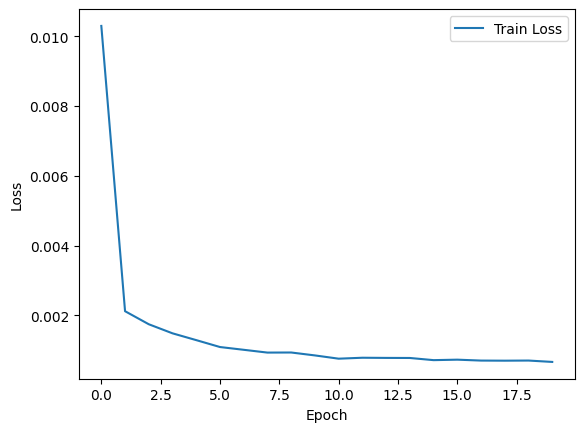

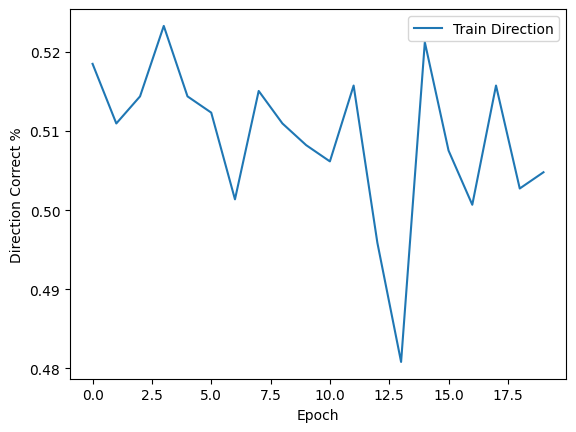

100%|██████████| 365/365 [00:00<00:00, 825.81it/s]


Normalized Test Loss: 0.0261, Unnormalized Test Loss: 19.2840


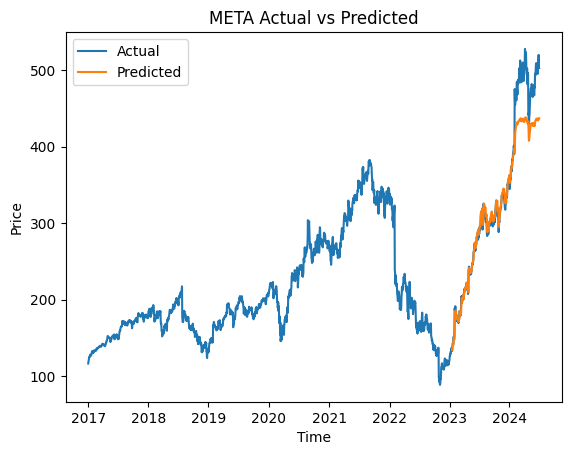

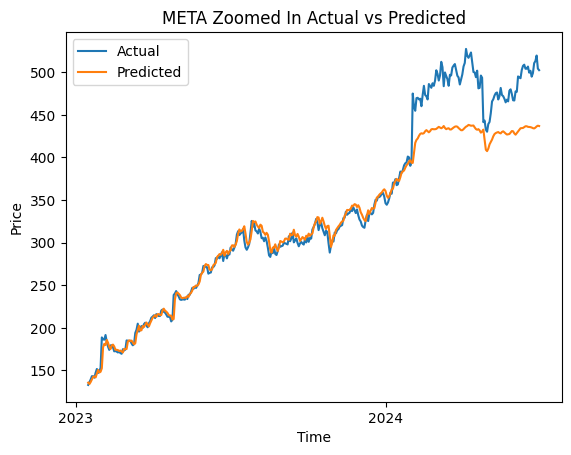

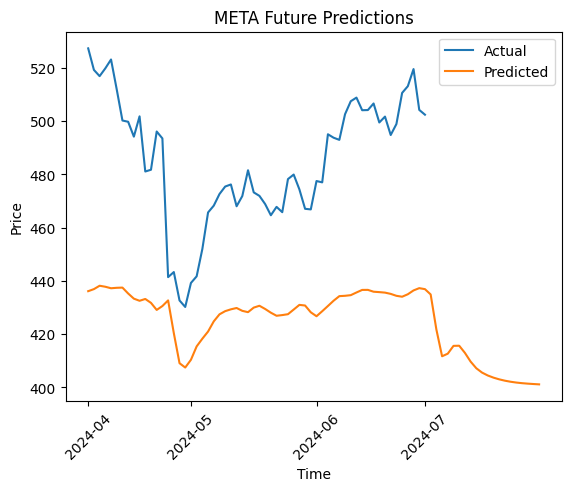

[434.87215623 421.71966076 411.64582439 412.6237404  415.55342486
 415.60725773 412.92103638 409.63772742 407.13540023 405.51331896
 404.42682256 403.61804892 402.97831312 402.46943564 402.071791
 401.76777897 401.53772182 401.36011253 401.21489442 401.08696294]


In [34]:
def main(ticker,lookback=15,lookforward=5,batch_size=1,num_epochs=5):
  data, model, train_losses, train_directions, test_loader, test_indices = get_model(ticker,lookback,lookforward,batch_size,num_epochs)
  if(len(train_losses) != 0):
    plot_data(train_losses,train_directions)
  predictions, actual, future_predictions = get_predictions(model,data, test_loader)
  plot_results(predictions, future_predictions, actual, data, test_indices)

main("META",lookback=60,lookforward=20,batch_size=1,num_epochs=20)